In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
from PIL import Image 
from PIL import ImageEnhance
from skimage.io import imread
import matplotlib.pyplot as plt

import os, random, pathlib, warnings, itertools, math
warnings.filterwarnings("ignore")

import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.metrics import confusion_matrix,classification_report

from tensorflow.keras import models
from tensorflow.keras.models import load_model
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, LeakyReLU
from tensorflow.keras.layers import BatchNormalization, Activation, Conv2D 
from tensorflow.keras.layers import GlobalAveragePooling2D, Lambda
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.preprocessing import image

K.clear_session()

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
!unzip /gdrive/MyDrive/dataset/cassava-leaf.zip > /dev/null

In [ ]:
train_folder = "/content/cassava-leaf-disease/train"
test_folder = "/content/cassava-leaf-disease/val"


In [ ]:
def count_files(rootdir):
    '''counts the number of files in each subfolder in a directory'''
    for path in pathlib.Path(rootdir).iterdir():
        if path.is_dir():
            print("There are " + str(len([name for name in os.listdir(path) \
            if os.path.isfile(os.path.join(path, name))])) + " files in " + \
            str(path.name))
 
count_files(os.path.join(train_folder))


There are 1526 files in Cassava Brown Streak Disease (CBSD)
There are 9178 files in Cassava Mosaic Disease (CMD)
There are 1663 files in Cassava Green Mottle (CGM)
There are 1797 files in Healthy
There are 757 files in Cassava Bacterial Blight (CBB)


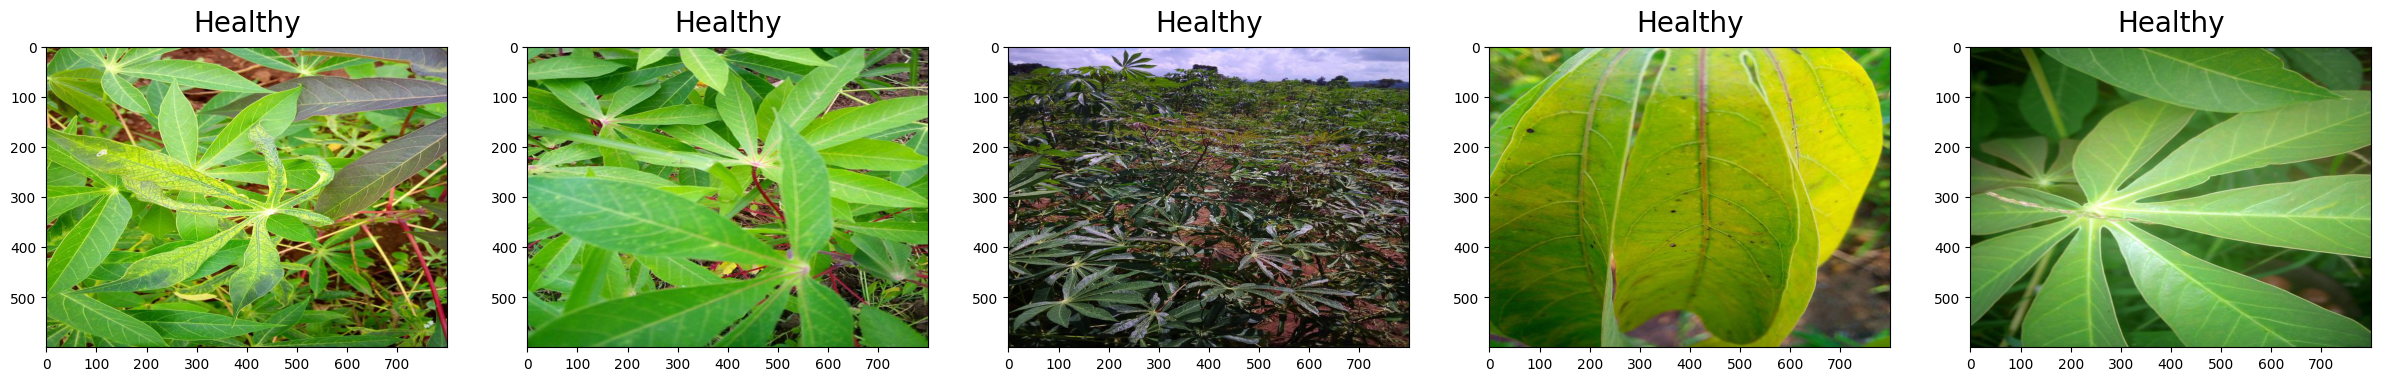

In [ ]:
select_folder="Healthy"
rows,columns = 1,5

display_folder=os.path.join(train_folder,select_folder)
total_images=rows*columns
fig=plt.figure(1, figsize=(30, 10))

for i,j in enumerate(os.listdir(display_folder)):      
    
    img = plt.imread(os.path.join(train_folder,select_folder,j))
    fig=plt.subplot(rows, columns, i+1)
    fig.set_title(select_folder, pad = 11, size=20)
    plt.imshow(img)
    
    if i==total_images-1:
        break

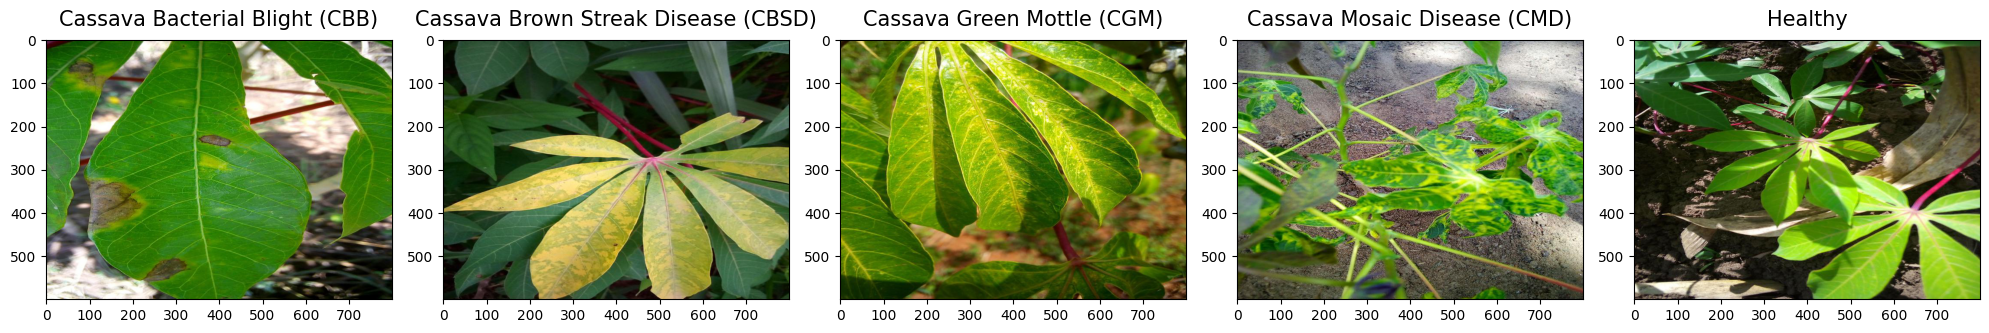

In [ ]:
images = []

for image_folder in sorted(os.listdir(train_folder)):
    leaf = os.listdir(train_folder + '/' + image_folder)
    img_selected = np.random.choice(leaf)
    images.append(os.path.join(train_folder,image_folder,img_selected))
                                     
fig=plt.figure(1, figsize=(20, 20))

for subplot,image_ in enumerate(images):
    category=image_.split('/')[-2]
    imgs = plt.imread(image_)
    a,b,c=imgs.shape
    fig=plt.subplot(1, 5, subplot+1)
    fig.set_title(category, pad = 10,size=15)
    plt.imshow(imgs)
    
plt.tight_layout()

In [2]:
n_cat =5

batch_size = 48
batch_size_predict = 64
input_shape = [299,299]


In [3]:
densnet = tf.keras.applications.densenet.DenseNet201(input_shape=input_shape + [3], weights='imagenet', include_top=False)
for layer in densnet.layers[:100]:
    layer.trainable = False

x = densnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x)
x = Dropout(0.2)(x)

prediction = Dense(n_cat, activation='softmax')(x)

model = Model(inputs=densnet.input, outputs=prediction)

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

model.summary()

74836368/74836368 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 305, 305, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 150, 150, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                             

In [ ]:
train_datagen = image.ImageDataGenerator(rescale = 1./255,
                                         shear_range = 0.2,
                                         zoom_range = 0.2,
                                         horizontal_flip = True)

test_datagen = image.ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(
    train_folder,
    target_size = (229, 229),
    batch_size = 48,
    class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(
    test_folder, 
    target_size = (229, 229),
    batch_size = 48, 
    class_mode = 'categorical')

Found 14921 images belonging to 5 classes.
Found 4270 images belonging to 5 classes.


In [ ]:
class_map = training_set.class_indices
class_map

{'Cassava Bacterial Blight (CBB)': 0,
 'Cassava Brown Streak Disease (CBSD)': 1,
 'Cassava Green Mottle (CGM)': 2,
 'Cassava Mosaic Disease (CMD)': 3,
 'Healthy': 4}

In [ ]:
Model = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=30,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/30
311/311 [==============================] - 483s 1s/step - loss: 0.8231 - accuracy: 0.7087 - val_loss: 1.0374 - val_accuracy: 0.7059
Epoch 2/30
311/311 [==============================] - 439s 1s/step - loss: 0.6329 - accuracy: 0.7702 - val_loss: 3.6304 - val_accuracy: 0.4478
Epoch 3/30
311/311 [==============================] - 397s 1s/step - loss: 0.5741 - accuracy: 0.7932 - val_loss: 0.5823 - val_accuracy: 0.7909
Epoch 4/30
311/311 [==============================] - 397s 1s/step - loss: 0.5218 - accuracy: 0.8111 - val_loss: 0.6043 - val_accuracy: 0.7806
Epoch 5/30
311/311 [==============================] - 400s 1s/step - loss: 0.4727 - accuracy: 0.8323 - val_loss: 0.4811 - val_accuracy: 0.8321
Epoch 6/30
311/311 [==============================] - 393s 1s/step - loss: 0.4325 - accuracy: 0.8428 - val_loss: 0.5494 - val_accuracy: 0.8059
Epoch 7/30
311/311 [==============================] - 389s 1s/step - loss: 0.3893 - accuracy: 0.8577 - val_loss: 0.4919 - val_accuracy: 0.8403

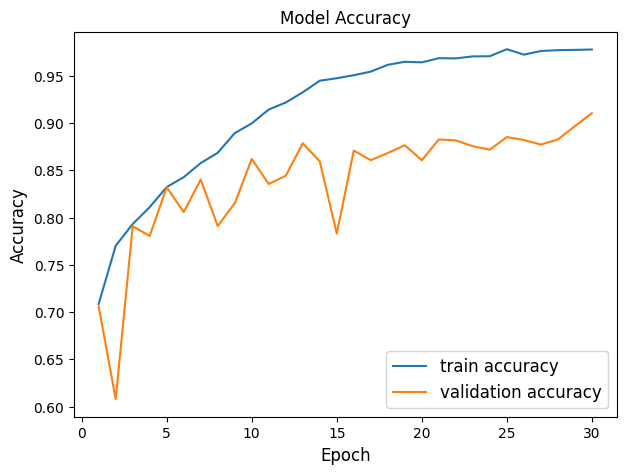

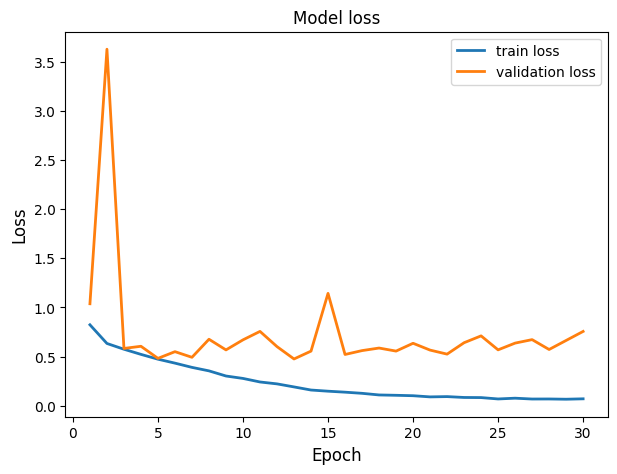

In [22]:
def plot_accuracy(history):
    
    plt.plot(history.history['accuracy'],label='train accuracy')
    plt.plot(history.history['val_accuracy'],label='validation accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Accuracy_v1_InceptionV3')
    plt.show()
    
def plot_loss(history):
    
    plt.plot(history.history['loss'],label="train loss")
    plt.plot(history.history['val_loss'],label="validation loss")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Loss_v1_InceptionV3')
    plt.show()
    
plot_accuracy(Model)
plot_loss(Model)

In [23]:
# Using the test dataset
score = model.evaluate_generator(test_set)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.7556507880449295 
Test accuracy: 0.89061637115479
